<a href="https://colab.research.google.com/github/marceloqs/VRDL_Tarea2/blob/master/Tarea_2_NLP_(grupo_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

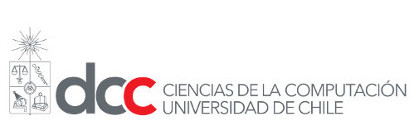

#Diplomado Inteligencia Artificial
#Procesamiento de Lenguaje Natural

##***Grupo 2***
## **Wladimir Cortes**
## **Jaime Fuenzalida**
## **Marcelo Quiroga**


### 1. Creacion y limpieza de la base de datos


In [1]:
#Se descarga dataset
!git clone https://github.com/wladimircortes/chatbot

fatal: destination path 'chatbot' already exists and is not an empty directory.


In [2]:
#Se instalan programas
!pip install nlpaug
!pip install datasets transformers 
!pip install colorama 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Librerias
import pandas as pd
import numpy as np
import nltk
import gensim
import re
import sklearn
import sklearn.linear_model
import sklearn.model_selection
import random
import importlib
import os
import matplotlib.pyplot as plt
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import warnings
from nlpaug.util import Action
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.model_selection import train_test_split
from datasets import load_dataset, load_metric, Dataset, DatasetDict, concatenate_datasets
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
from colorama import Fore, Style



####**Se generan las siguientes tablas:**####

1. Tabla con los mensajes de entrada para nuestro chatbot.<br>
Esta tabla se compone de las clases: nombre, saludo y despedida

In [4]:
mensajes_entrada = pd.read_excel('/content/chatbot/mensajes entrada.xlsx')

2. Tabla con los mensajes de respiuestas predeterminados para nuestro chatbot.<br>
Esta tabla se compone de las clases: nombre, saludo y despedida

In [5]:
respuestas_salida = pd.read_excel('/content/chatbot/respuestas salida.xlsx')

3. Tabla con los mensajes de informacion para nuestro chatbot. <br>
Esta tabla se compone de la clase: informacion

In [6]:
tablaQA = pd.read_excel('/content/chatbot/tablaQA.xlsx')

4. Tabla con los mensajes de entrada junto con los mensajes de informacion.<br>
Esta tabla se compone de la clase: informacion

In [7]:
tablaQA_paso = pd.DataFrame(tablaQA['PREGUNTA']).rename(columns={'PREGUNTA':'MENSAJE'})
tablaQA_paso['CLASE'] = 'informacion'
mensajes_entrada=mensajes_entrada.append(tablaQA_paso, ignore_index=True)

### 2. Análisis de distancia 

**Se utilizarán los mensajes de entrada, de salidas, las preguntas y respuestas como corpus**

In [8]:
corpus=mensajes_entrada['MENSAJE'].append(tablaQA['RESPUESTA'],ignore_index=True)
corpus=corpus.append(respuestas_salida['RESPUESTA'],ignore_index=True)

Se descargan stopwords

In [9]:
nltk.download('stopwords')
nltk.download('wordnet') 
nltk_stopwords = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


####**Funciones necesarios para nuestro chatbot**

In [10]:
#Normalizacion - toma un texto de entrada y lo normaliza, dejando en texto en minusculas, sin acentos y puntos
def normalizer(text): #normalizes a given string to lowercase and changes all vowels to their base form
    text = text.lower()
    text = re.sub(r'[^A-Za-zñáéíóú 0-9]', ' ', text) 
    text = re.sub('á', 'a', text) 
    text = re.sub('é', 'e', text)
    text = re.sub('í', 'i', text)
    text = re.sub('ó', 'o', text)
    text = re.sub('ú', 'u', text)
    return text

#tokenizador - toma el texto de entrada y lo separa en tokens eliminando stopwords si se requiere 
def preprocessor(text, remove_stopwords = True):
  text = normalizer(text)
  if remove_stopwords:
    text = ' '.join([word for word in text.split() if word not in (nltk_stopwords)])
  tokens = nltk.tokenize.casual_tokenize(text)
  return tokens

#Vectorizacion - toma el texto de entrada y retorna una presentacion vectorial 
def vectorizer(text, model): 
    vectors = []
    for i in text:
        try:
            vectors.append(model.wv[i])
        except:
            vectors.append(np.zeros(100))
            pass
    return(np.nan_to_num(np.mean(vectors,axis=0))) 

warnings.filterwarnings('ignore')

**Entrenamos un modelo con Word2Vec con el corpus creado previamente**

In [11]:
corpus_preprocessed = list(map(preprocessor,corpus))
model_w2v = gensim.models.word2vec.Word2Vec(sentences = corpus_preprocessed, min_count=1)

**Se realiza grafico para visualizar la frecuencia de los mensajes por clase**

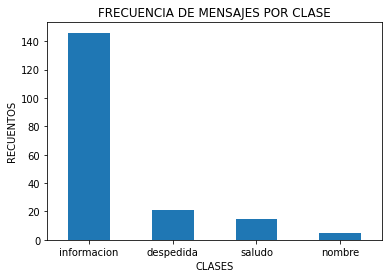

In [12]:
count_classes = pd.value_counts(mensajes_entrada.CLASE)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(4), mensajes_entrada.CLASE.unique().sort())
plt.title("FRECUENCIA DE MENSAJES POR CLASE")
plt.xlabel("CLASES")
plt.ylabel("RECUENTOS");

Se entrenará un modelo de regresión lineal para clasificar el tipo de mensaje, sin embargo atendido que las clases del dataset están desbalanceadas, en el modelo se agregará una penalización para compensar dicho error.

In [13]:
features = np.zeros(shape=(len(mensajes_entrada),model_w2v.wv.vectors.shape[1]))
for i,MENSAJE in enumerate(mensajes_entrada.MENSAJE):
  features[i,:] = vectorizer(preprocessor(MENSAJE),model_w2v)
cv_results = sklearn.model_selection.cross_validate(sklearn.linear_model.LogisticRegression(max_iter=1000, C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced"),features[:10000],mensajes_entrada.CLASE[:10000])
cv_results["test_score"].mean()

0.8817923186344239

**Se realizaron  algunas pruebas para mejorar el test_score, de las pruebas se realizaron los siguientes cambios:**<br>
1. Sin eliminar stopword <br>
    0.7591749644381224
2. Eliminando stopword <br>
    **0.8605974395448079**
3. Eliminando stopword y palabras > 3 <br>
    0.8233285917496443

**Hasta ahora lo que funciona mejor es solo quitando las stopsword (prueba 2)**

In [14]:
clf = sklearn.linear_model.LogisticRegression(max_iter=500, C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
clf.fit(features[:10000],mensajes_entrada.CLASE[:10000])

LogisticRegression(class_weight='balanced', max_iter=500, random_state=1,
                   solver='newton-cg')

In [15]:
#
def classify(mensaje):
  tokens = preprocessor(mensaje)
  vector = vectorizer(tokens,model_w2v).reshape(1, -1)
  return clf.predict(vector)[0] 

# Normalizar los vectores para que sean unitarios
def normalize(data) :
    norm = np.sqrt(np.sum(np.square(data), axis=1))
    norm = np.expand_dims(norm, 0)        
    data = data / np.transpose(norm)
    return data

# Retorna un ranking de las preguntas y respuestas más similares
def query(fv, query):
    normalized_fv = normalize(fv)
    normalized_query = normalize(query)
    sim=cosine_similarity(normalized_query, normalized_fv)
    idx_sorted = np.argsort(-sim, axis=-1)
    return idx_sorted

# Recupera respuesta mas similar a la pregunta del humano
def retrieve(message,message_class):
  try:
    if message_class=='informacion':
        tablaQA_all=tablaQA.PREGUNTA.str.cat(tablaQA.RESPUESTA)
        features = np.zeros(shape=(len(tablaQA),model_w2v.wv.vectors.shape[1]))
        for i,PREGUNTA in enumerate(tablaQA_all):
          features[i,:] = vectorizer(preprocessor(PREGUNTA),model_w2v)
        vector_message = vectorizer(preprocessor(message),model_w2v).reshape(1, -1)
        ranking = query(features, vector_message)
        return tablaQA.loc[ranking[0][0]][1]
    else:
        response_class=respuestas_salida[respuestas_salida.CLASE==message_class].reset_index(drop=True)
        features = np.zeros(shape=(len(response_class),model_w2v.wv.vectors.shape[1]))
        for i,RESPUESTA in enumerate(response_class.RESPUESTA):
          features[i,:] = vectorizer(preprocessor(RESPUESTA),model_w2v)
        vector_message = vectorizer(preprocessor(message),model_w2v).reshape(1, -1)
        ranking = query(features, vector_message)
        return response_class.loc[ranking[0][random.randrange(0, 2)]][0]
  except:
    return("Pregunta desconocida")        

**Chatbot**

In [16]:
print("Bienvenid@ \n")

mesage_class = ''
while mesage_class != "despedida": 
  print ("Ingrese texto :")
  message = input()
  mesage_class=classify(message)
  request = retrieve(message,mesage_class)
  if  request == 'Pregunta desconocida':
    print("Pregunta desconocida, vuelve a intentar")
    mesage_class = 'unknown'
    continue
  print("")
  print(f"- Humano : {message}. \n+ Bot    : {request}.")
  print("* Categoria :" + mesage_class) 
  print("---------------------------------------")


Bienvenid@ 

Ingrese texto :
cómo ingreso un escrito?

- Humano : cómo ingreso un escrito?. 
+ Bot    : En casos de caída de la Oficina Judicial Virtual, el usuario podrá ingresar materialmente el escrito de plazo, y como respaldo a dicha circunstancia, contará con el Certificado de Disponibilidad emitido por la Corporación Administrativa del Poder Judicial. El tribunal estará encargado de digitalizar el escrito y adjuntarlo a la carpeta electrónica para su correspondiente.
* Categoria :informacion
---------------------------------------
Ingrese texto :
chao

- Humano : chao. 
+ Bot    : Nos vemos.
* Categoria :despedida
---------------------------------------


### 3. Análisis transformer

**Aumento de datos**

In [17]:
!%load_ext autoreload
!%autoreload 2

os.environ["MODEL_DIR"] = '../model'

/bin/bash: line 0: fg: no job control
/bin/bash: line 0: fg: no job control


In [18]:
clases = pd.DataFrame({'CLASE': ['informacion', 'nombre', 'saludo', 'despedida'],'ID_CLASE': [0, 1, 2, 3]})
mensajes_entrada=mensajes_entrada.merge(clases, left_on='CLASE', right_on='CLASE')
mensajes_entrada=mensajes_entrada.rename(columns={"MENSAJE": "text", "ID_CLASE": "label"})

aug = naw.SynonymAug(aug_src='wordnet', lang='spa')
da_mensajes_entrada=mensajes_entrada
da_mensajes_entrada.text=mensajes_entrada.text.apply(lambda x: ''.join(aug.augment(x)))
mensajes_entrada=mensajes_entrada.append(da_mensajes_entrada, ignore_index=True)

####Preparación del dataset

In [19]:
x_train, x_test, y_train, y_test = train_test_split( mensajes_entrada.text, mensajes_entrada.label, test_size=0.33, random_state=42)
train = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
test = pd.concat([x_test, y_test], axis=1).reset_index(drop=True)

#### Preparación del modelo transforme de clasificación 

In [20]:
datasets_train_test = DatasetDict({
   "train": Dataset.from_pandas(train),
   "test": Dataset.from_pandas(test)
   })

In [21]:
metric = load_metric('accuracy')

In [22]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

In [23]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [24]:
tokenized_spanish_diagnostics = datasets_train_test.map(preprocess_function, batched=True)
model = AutoModelForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", num_labels=4)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [25]:
training_args = TrainingArguments(
    output_dir="./results",
    max_steps=500,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer = tokenizer,
    train_dataset=tokenized_spanish_diagnostics["train"],
    eval_dataset=tokenized_spanish_diagnostics["test"],
    compute_metrics=compute_metrics
)

max_steps is given, it will override any value given in num_train_epochs


In [26]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 250
  Num Epochs = 16
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 500
  Number of trainable parameters = 109853956
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
500,0.029900,0.001855,1.000000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 124
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=500, training_loss=0.02988555145263672, metrics={'train_runtime': 49.8028, 'train_samples_per_second': 80.317, 'train_steps_per_second': 10.04, 'total_flos': 58146531809184.0, 'train_loss': 0.02988555145263672, 'epoch': 15.62})

In [27]:
classifier = pipeline("text-classification", model = model, tokenizer=tokenizer, device=0)

### Preparación del modelo Transformers de preguntas y respuestas 

In [28]:
nlp_qa = pipeline('question-answering', 
        model='mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es',
        tokenizer=('mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es', {"use_fast": False})
    )

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--mrm8488--distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es/snapshots/a8842522e00a16b382c875ecb2da2dd8cf7cf5b6/config.json
Model config BertConfig {
  "_name_or_path": "mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31002
}

loading configuration file config.json from cache at /root/.cache/hugg

## Chat Bot con Transformers

#### Se crean funciones necesarias para el chatbot con transformers

In [29]:
def classify(mensaje):
    tokens = preprocessor(mensaje)
    vector = vectorizer(tokens,model).reshape(1, -1)
    return clf.predict(vector)[0] 

def normalize(data) :
    # Normalizar los vectores para que sean unitarios
    norm = np.sqrt(np.sum(np.square(data), axis=1))
    norm = np.expand_dims(norm, 0)        
    data = data / np.transpose(norm)
    return data

def query(fv, query):
    # Retorna un ranking de las preguntas y respuestas más similares
    normalized_fv = normalize(fv)
    normalized_query = normalize(query)
    sim=cosine_similarity(normalized_query, normalized_fv)
    idx_sorted = np.argsort(-sim, axis=-1)
    return idx_sorted

def get_answers(conext, question):
    best_score=-10
    best_answer={}
    for text in conext.RESPUESTA:
      answer=nlp_qa({'question': question, 'context': text})
      if answer['score']>best_score:
        best_answer={'start':answer['start'], 'end':answer['end'], 'text':text}
        best_score=answer['score']
    return best_answer

def question_the_robot(message):
    # Recupera las respuesta mas similar a la pregunta del humano
    message_class_label=int(classifier(message)[0]['label'][6:])# Clasificamos la pregunta, con el modelo transformer
    message_class=clases.loc[message_class_label].CLASE #decodifica el label del transformer en las clases definidas en los mensajes de entrada
    if message_class=='informacion': # si la clase es informacion, buscara las respuestas mas similares y dentro de ellas con transformes se dara una respuesta
        tablaQA_all=tablaQA.PREGUNTA.str.cat(tablaQA.RESPUESTA) # une las preguntas y las respuestas de la tablaQA
        features = np.zeros(shape=(len(tablaQA_all),model_w2v.wv.vectors.shape[1])) #vectoriza la tablaQA
        for i,tex in enumerate(tablaQA_all): #vectoriza la tablaQA
          features[i,:] = vectorizer(preprocessor(tex),model_w2v) #vectoriza la tablaQA
        vector_message = vectorizer(preprocessor(message),model_w2v).reshape(1, -1) # se vectoriza el mensaje o pregunta
        ranking = query(features, vector_message)# ranking con de respuestas mas similares
        bests_answers= pd.DataFrame(tablaQA.iloc[ranking[0][0:3]].RESPUESTA) # obtiene las 3 mejores respuestas
        best_answer=get_answers(bests_answers,message ) # onbtiene la mejor respuesta con el tranformer
        text=best_answer['text']
        start=best_answer['start']
        end=best_answer['end']
        return f'{text[:start]}{Fore.RED}{text[start:end]}{Style.RESET_ALL}{text[end:]}'
    else:
        response_class=respuestas_salida[respuestas_salida.CLASE==message_class].reset_index(drop=True)
        features = np.zeros(shape=(len(response_class),model_w2v.wv.vectors.shape[1]))
        for i,RESPUESTA in enumerate(response_class.RESPUESTA):
          features[i,:] = vectorizer(preprocessor(RESPUESTA),model_w2v)
        vector_message = vectorizer(preprocessor(message),model_w2v).reshape(1, -1)
        ranking = query(features, vector_message)
        return response_class.loc[ranking[0][random.randrange(0, 2)]][0]

####Rutina para consultar a Chatbot

####conjunto de preguntas de pruebas

In [30]:
print("=========================Chat Bot==========================")
message='Hola, cómo estás'
print(f"- Humano : {message}. \n+ Bot    : {question_the_robot(message)}.")
print("===========================================================")
message='Cómo te llamas'
print(f"- Humano : {message}. \n+ Bot    : {question_the_robot(message)}.")
print("===========================================================")
message='que hago si olvide la clave unica'
print(f"- Humano : {message}. \n+ Bot    : {question_the_robot(message)}.")
print("===========================================================")
message='cómo ingreso un escrito?'
print(f"- Humano : {message}. \n+ Bot    : {question_the_robot(message)}.")
print("===========================================================")
message='que es la ley de tramitacion electronica?'
print(f"- Humano : {message}. \n+ Bot    : {question_the_robot(message)}.")
print("===========================================================")
message='como puedo revisar mis causas?'
print(f"- Humano : {message}. \n+ Bot    : {question_the_robot(message)}.")
print("===========================================================")
message='Hasta luego muchas gracias por su ayuda'
print(f"- Humano : {message}. \n+ Bot    : {question_the_robot(message)}.")
print("===========================================================")

=========================Chat Bot==========================
- Humano : Hola, cómo estás. 
+ Bot    : Hola muy bien y usted.
- Humano : Cómo te llamas. 
+ Bot    : Robotin es mi nombre, cómo puedo ayudarle.
- Humano : que hago si olvide la clave unica. 
+ Bot    : Si el usuario no recuerda su Clave Única debe recuperarla en el sitio web de Registro Civil e Identificación, mediante las opciones que ahí se entregan, como correo electrónico o preguntas secretas que el usuario completó al activar su Clave..
- Humano : cómo ingreso un escrito?. 
+ Bot    : Existen dos canales para resolver sus dudas:
- A través de un formulario escrito que se encuentra disponible en la opción de contacto de la Oficina Judicial Virtual y en la página www.tramitacionelectrónica.cl
- Comunicándose con la Mesa de Ayuda de la Ley de Tramitación Electrónica que el Poder Judicial ha puesto a disposición de sus usuarios, cuyo horario de atención es de lunes a viernes desde 8:00 a 17:00 horas y el número de contacto 